In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('spam.csv' , encoding='latin1')
df.head()
df.info()
        #DATA CLEANING
#drop last 3 col
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
df.info()

#renaming column
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.sample(5)

#char -> number using label encoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
df.head()

#check for missing values
df.isnull().sum()

#check fo rduplicate values
df.duplicated().sum()
df = df.drop_duplicates(keep='first')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [2]:
df.shape

(5169, 2)

2. EDA - exploratory data analysis
check how much %is spam and ham
ham -> 0 , spam -> 1


In [3]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

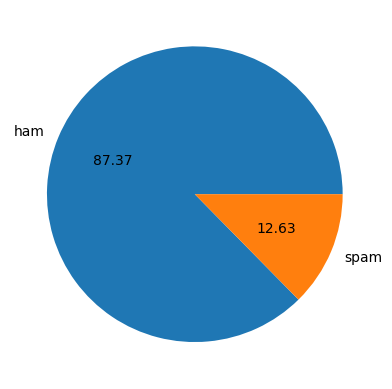

In [4]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham','spam'], autopct="%0.2f")
plt.show()

what we analysed?
1. calculated % of ham and spam-> ham >>> spam. data is imbalanced

next we make 3 columns(3 new features)
c1 -> no. of char
c2 -> no. of words
c3 -> no. of sentences. 
for that we need nltk lib

In [5]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
#num of chars
df['num_char'] = df['text'].apply(len)
df.head()

#num of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

#num of sentences
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

#describe is used to see mean,std,count
df[['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


lets analyse the columns of ham and spam separately

In [7]:
#for ham msgs (target = 0(ham))
df[df['target'] == 0][['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [8]:
#target = 1(spam)
df[df['target'] == 1][['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


clearly, if we see mean of both ham and spam. spam msgs are longer than ham
spam has 137 char per sentences and ham-> 70 char per sentence

In [9]:
#plot histogram
import seaborn as sns

<Axes: xlabel='num_char', ylabel='Count'>

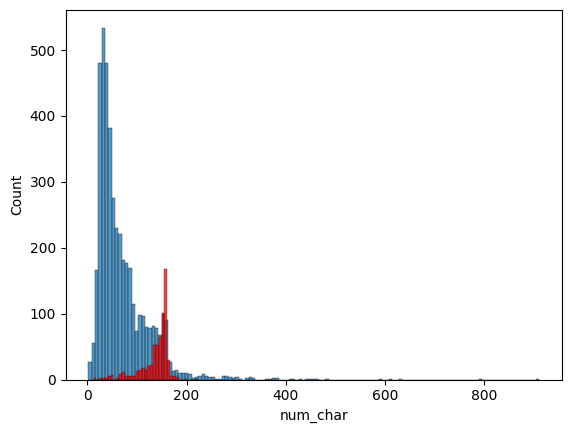

In [10]:
sns.histplot(df[df['target'] == 0]['num_char'])
sns.histplot(df[df['target'] == 1]['num_char'],color='red')

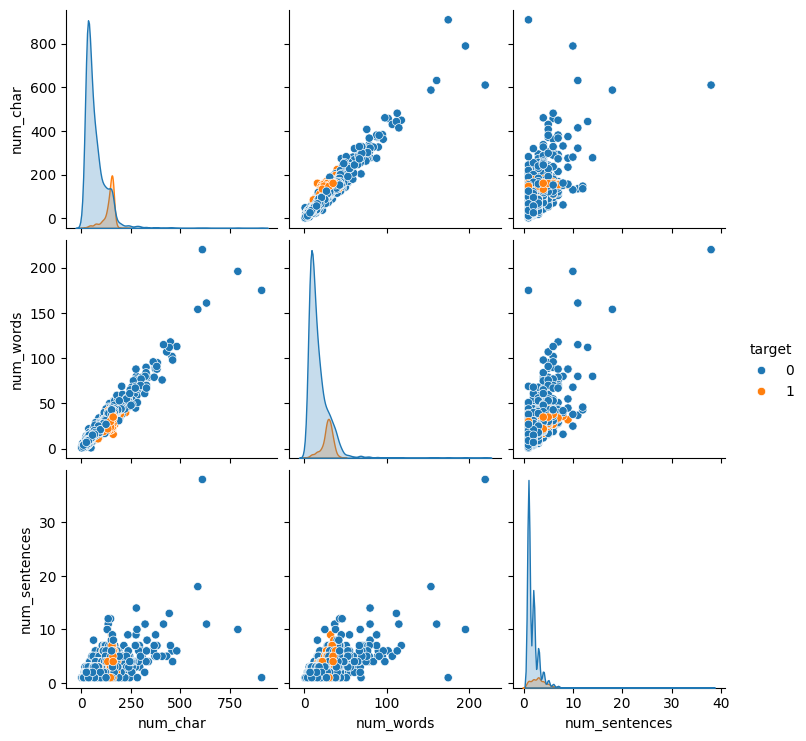

In [11]:
sns.pairplot(df,hue='target')

there are visible outliers, which can hamper model

<Axes: >

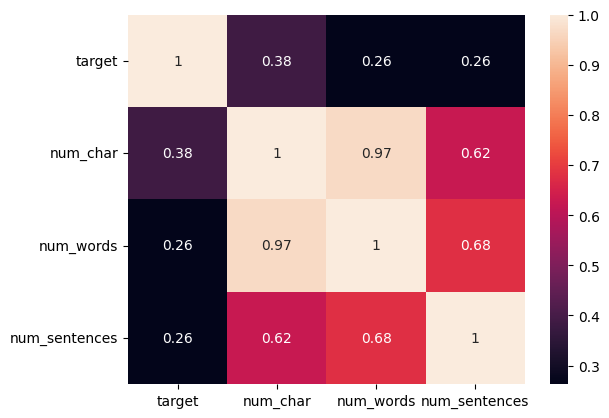

In [12]:
sns.heatmap(df.select_dtypes(include='number').corr(),annot=True)

heatmap tells us how to decide which numeric text-based feature is best for spam detection.
target vs num_char = 0.38  (strongest). -> Messages with more characters are more likely to be spam(target = 1).
Which feature should you choose? ->num_char as it has Highest correlation with target

3. data preprocessing
lower case, tokenization, removing special char, removing stop words(ex-> is, of, the,by) and punctuation, stemming(convert same tpe of word into single word ex-> dance, dancing, dances to 'dance')

create a nw single func to perform all these step 

In [13]:

from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
#example what stem do
ps.stem('dancing')



'danc'

In [14]:
def transform_text(text):
    #1. converted to lower
    text = text.lower()

    #2. tokenize the words and return list
    text = nltk.word_tokenize(text) 
    # we can run a loop on list to remove special char

    #3. removed special char
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    #4. removed stopwords and punctuation
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    #5. stemming
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    return " ".join(y)
    

In [15]:
# 1st mail
df['text'][0] 

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [16]:
transform_text('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

In [17]:
df['transformed_text'] = df['text'].apply(transform_text)

In [18]:
df.head()

,target,text,num_char,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


now generate the word cloud model 

In [19]:
from wordcloud import WordCloud
wc = WordCloud(width=500, height=500, min_font_size=10,background_color = 'white')

In [20]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

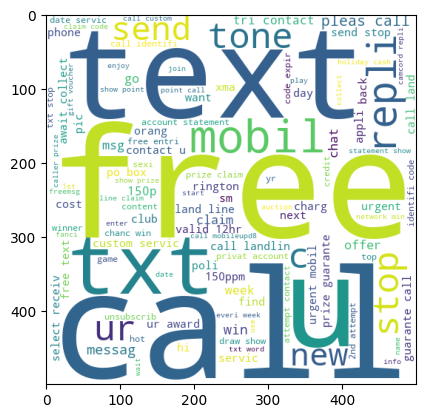

In [21]:
plt.imshow(spam_wc)

In [22]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

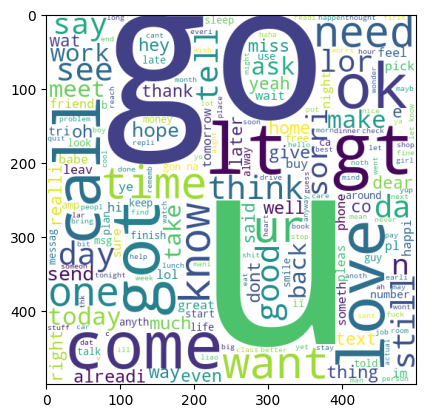

In [23]:
plt.imshow(ham_wc)

now lets find out what are the top 30 most used words

creating an empty list "spam_corpus" and adding frequet words in that list

In [24]:
df.columns

Index(['target', 'text', 'num_char', 'num_words', 'num_sentences',
       'transformed_text'],
      dtype='object')

In [25]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist(): #converts msg into list so we apply loop
    for word in msg.split():
        spam_corpus.append(word)

In [26]:
type(spam_corpus)


list

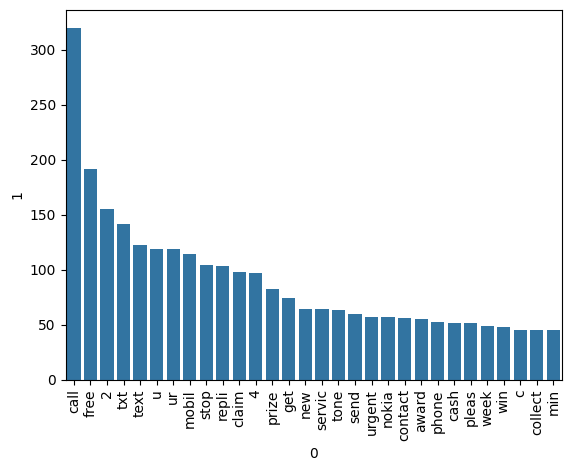

In [27]:
#collection -> library
#spam_corpus is being converted to dictionary
# using counter we can most common 30 words from spam_corpus
from collections import Counter
#creating a data frame 
freq_df = pd.DataFrame(Counter(spam_corpus).most_common(30))
sns.barplot(x=0, y=1, data=freq_df)
plt.xticks(rotation='vertical')
plt.show()


In [28]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist(): #converts msg into list so we apply loop
    for word in msg.split():
        ham_corpus.append(word)

In [29]:
len(ham_corpus)

35404

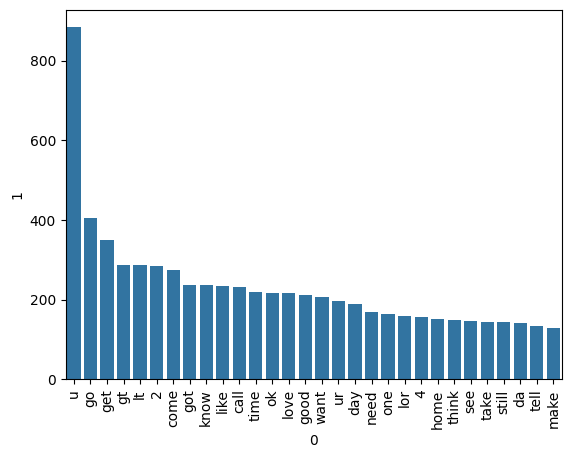

In [30]:
from collections import Counter
#creating a data frame 
freq_df = pd.DataFrame(Counter(ham_corpus).most_common(30))
sns.barplot(x=0, y=1, data=freq_df)
plt.xticks(rotation='vertical')
plt.show()

MODEL BUILDING
the best performance for textual data is given by naive bayes
1) text vectorization
2) input vector in naive bayes to get op


text needs to be converted into numeric or vectors ka VECTORIZATION
this can be done in few ways
1) bag of words
2) tfidf
3) word to vec
we will use bag of words

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer()

In [32]:

X = tfidf.fit_transform(df['transformed_text']).toarray()

In [33]:
X.shape

(5169, 6708)

In [34]:
y = df['target'].values

In [35]:
y

array([0, 0, 1, ..., 0, 0, 0], shape=(5169,))

data splitting 

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)


In [38]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [39]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [40]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))


0.8762088974854932
[[793 103]
 [ 25 113]]
0.5231481481481481


In [41]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))


0.9593810444874274
[[896   0]
 [ 42  96]]
1.0


In [42]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9700193423597679
[[893   3]
 [ 28 110]]
0.9734513274336283


since precision matters the most here and mnb is giving high precision so using mnb

BUT LETS CHECK MORE MODELS

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 

In [44]:
svc = SVC(kernel='sigmoid',gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear',penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=10, random_state=2, n_jobs=1)  # Reduced estimators and disabled parallelization
etc = ExtraTreesClassifier(n_estimators=10, random_state=2, n_jobs=1)  # Reduced estimators and disabled parallelization
gbdc = GradientBoostingClassifier(n_estimators=10, random_state=2)  # Reduced estimators
xgb = XGBClassifier(n_estimators=10, random_state=2)  # Reduced estimators


In [45]:
clfs = {
    'SVC' : svc,
    'KN' : knc,
    'NB' : mnb,
    'DT' : dtc,
    'LR' : lrc,
    'RF' : rfc,
    'AdaBoost': abc,
    'Bgc' : bc,
    'ETC' : etc,
    'GBDT' : gbdc,
    'xgb' : xgb
}

In [46]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    return accuracy, precision

In [47]:
#example of above function
train_classifier(svc, X_train, y_train, X_test, y_test)

(0.9729206963249516, 0.9741379310344828)

In [48]:
#instead lets run a loop over clf to check accuracy and precision of every model
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    current_accuracy, current_precision = train_classifier(clf, X_train, y_train, X_test, y_test)

    print("for ", name)
    print("Accuracy = ", current_accuracy)
    print("precision = ", current_precision)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

    

for  SVC
Accuracy =  0.9729206963249516
precision =  0.9741379310344828
for  KN
Accuracy =  0.9003868471953579
precision =  1.0
for  NB
Accuracy =  0.9593810444874274
precision =  1.0
for  DT
Accuracy =  0.9361702127659575
precision =  0.8461538461538461
for  LR
Accuracy =  0.9516441005802708
precision =  0.94
for  RF
Accuracy =  0.971953578336557
precision =  1.0
for  AdaBoost
Accuracy =  0.9245647969052224
precision =  0.8409090909090909
for  Bgc
Accuracy =  0.9535783365570599
precision =  0.8571428571428571
for  ETC
Accuracy =  0.9622823984526112
precision =  0.9805825242718447
for  GBDT
Accuracy =  0.9119922630560928
precision =  0.8983050847457628
for  xgb
Accuracy =  0.9516441005802708
precision =  0.9074074074074074


In [49]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'precision':precision_scores}).sort_values(by='precision', ascending=False).reset_index(drop=True)

In [50]:
performance_df

,Algorithm,Accuracy,precision
0,KN,0.900387,1.000000
1,NB,0.959381,1.000000
2,RF,0.971954,1.000000
3,ETC,0.962282,0.980583
4,SVC,0.972921,0.974138
5,LR,0.951644,0.940000
6,xgb,0.951644,0.907407
7,GBDT,0.911992,0.898305
8,Bgc,0.953578,0.857143
9,DT,0.936170,0.846154


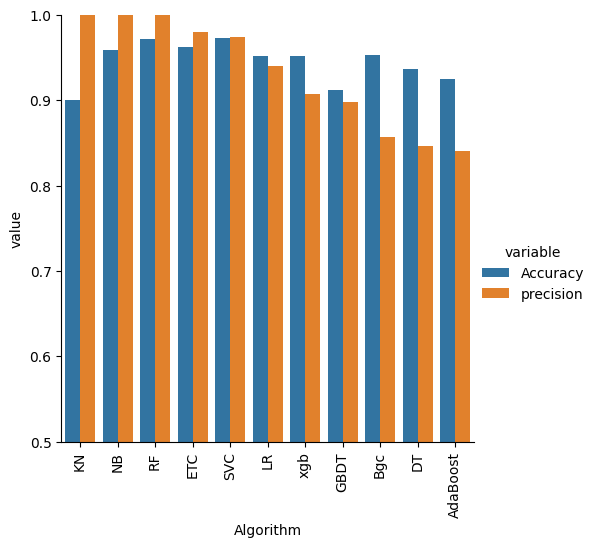

In [51]:
# Melt the dataframe to long format for catplot
perf_melted = performance_df.melt(id_vars='Algorithm', var_name='variable', value_name='value')

sns.catplot(x='Algorithm', y='value',
            hue='variable', data=perf_melted, kind='bar', height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

Improve model 

1) instead of taking all uniques words during vectorization, lets just take restricted most used words
try to optimize it using various techniques
for now lets just choose rf, using it create pipeline and convert into website


summarizing what we are doing
1) text pre processing(convert into lowercase, lamitization, remove stopwords)
2) vectorize
3) apply algo

In [52]:
import pickle
pickle.dump(tfidf, open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))